In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import h5py
from scipy import io
import os
import glob
import pywt

preparing data for training

(40, 450, 1)


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


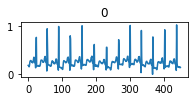

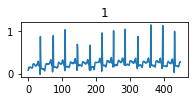

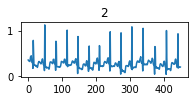

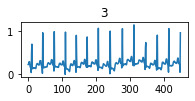

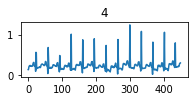

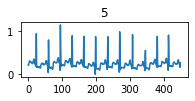

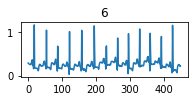

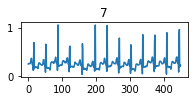

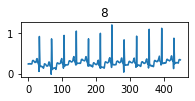

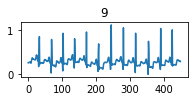

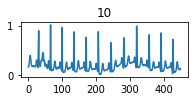

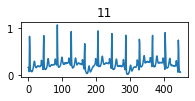

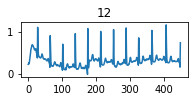

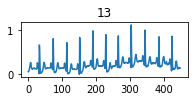

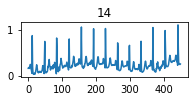

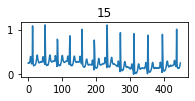

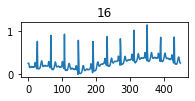

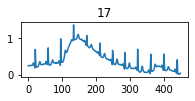

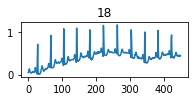

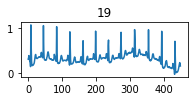

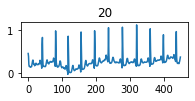

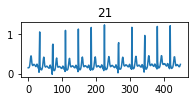

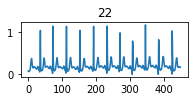

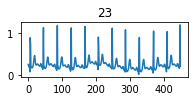

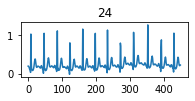

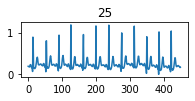

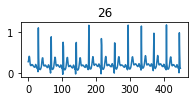

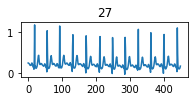

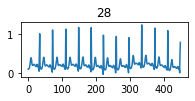

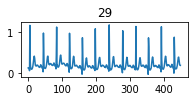

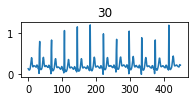

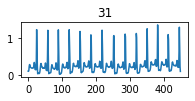

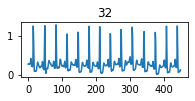

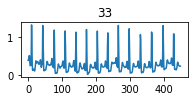

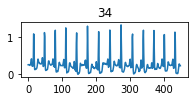

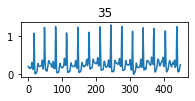

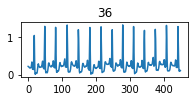

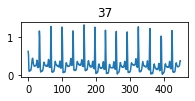

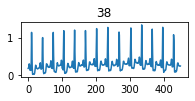

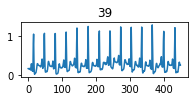

In [2]:
arr = []
for file in glob.glob('MLII/1 NSR/*.mat'):
    arr.append(file) 

arr = sorted(arr, key=lambda x:x[:])

l = 40
ll = 1
d = np.int(3600/ll)
stride = 4
data = []
for i in range(l):
    db = io.loadmat(arr[i])    
    for j in range(ll):
        data.append((db['val'][0, j*d:(j+1)*d]-np.amin(db['val'][0, :]))/(np.amax(db['val'][0, :])-np.amin(db['val'][0, :])))
data = np.asarray(data).reshape(l*ll, d, 1)[:, ::stride]  

#seq_in = data

seq_in = []
for i in range(len(data)):
    # wavelet
    cA, cD = pywt.dwt(data[i,:,0], 'db2')
    # fft space
    #cD = np.log(np.fft.fft(data[i])+0.1)
    seq_in.append(cA)
seq_in = np.asarray(seq_in).reshape(l*ll, len(cA), 1)
if (seq_in.shape[1] % 2 == 1):  
    seq_in = seq_in[:,0:seq_in.shape[1]-1,:]
    
print (seq_in.shape)  

for i in range(0,len(seq_in),1):
    plt.figure(figsize=(3, 1))
    plt.plot(seq_in[i, :, 0])
    plt.title(np.str(i))

GANLSTM for ECG data

In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D, MaxPooling1D, Conv1D, Flatten, UpSampling1D, ZeroPadding1D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, RepeatVector
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2
import keras.backend as K

Using TensorFlow backend.


In [4]:
class GAN():
    def __init__(self, rows, channels):
        self.seq_length = rows
        self.channel = channels
        self.latent_dim = 100
        self.critic_loss = []
        self.gen_loss = []
        self.clip_value = 0.01
        self.n_critic = 5
        
        optimizer_c = RMSprop(lr=0.00005)
        optimizer_g = RMSprop(lr=0.00005)
        
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss, optimizer=optimizer_c, metrics=['accuracy'])

        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        self.critic.trainable = False
        validity = self.critic(generated_seq)
        self.combined = Model(z, validity)
        self.combined.compile(loss=self.wasserstein_loss, optimizer=optimizer_g)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_critic(self):

        model = Sequential()         
        model.add(Conv1D(filters=32, kernel_size=10, strides=4))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))                                
        model.add(Conv1D(filters=64, kernel_size=10, strides=4))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4)) 
        model.add(Conv1D(filters=128, kernel_size=10, strides=4))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))              
        model.add(Flatten())         
        model.add(Dense(1, activation='sigmoid'))
        
        seq = Input(shape=(self.seq_length, self.channel))
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        l = np.int(self.seq_length/2)
        ll = np.int(self.seq_length/4)
        model.add(Dense(l*64))
        model.add(Reshape((l, 64)))
        model.add(LSTM(64, return_sequences=True, kernel_regularizer=l1_l2(l1=0.0, l2=0.0))) 
        model.add(ZeroPadding1D(padding=(ll, ll+1)))
        model.add(LSTM(32, return_sequences=True, kernel_regularizer=l1_l2(l1=0.0, l2=0.0)))         
        model.add(Dense(self.channel))
        model.add(Activation('tanh'))
                
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=64, sample_interval=10):

        X_train = seq_in 
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            for _ in range(self.n_critic):
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_seqs = X_train[idx]
                
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) 
                gen_seqs = self.generator.predict(noise)            

                d_loss_real = self.critic.train_on_batch(real_seqs, real)
                d_loss_fake = self.critic.train_on_batch(gen_seqs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.critic_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.critic_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['critic', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [5]:
gan = GAN(rows=seq_in.shape[1], channels=seq_in.shape[2])    
gan.train(epochs=4000, batch_size=16, sample_interval=100)

W0908 19:54:19.186350 139900238796608 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 19:54:19.188820 139900238796608 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 19:54:19.193410 139900238796608 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 19:54:19.293278 139900238796608 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default 

0 [D loss: 0.249886] [G loss: 0.499733]


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.243743] [G loss: 0.487487]
200 [D loss: 0.243721] [G loss: 0.487505]
300 [D loss: 0.243770] [G loss: 0.487671]
400 [D loss: 0.243768] [G loss: 0.487686]
500 [D loss: 0.243776] [G loss: 0.487671]
600 [D loss: 0.243828] [G loss: 0.487496]
700 [D loss: 0.243687] [G loss: 0.487574]
800 [D loss: 0.243729] [G loss: 0.487466]
900 [D loss: 0.243797] [G loss: 0.487376]
1000 [D loss: 0.243661] [G loss: 0.487707]
1100 [D loss: 0.243787] [G loss: 0.487587]
1200 [D loss: 0.243694] [G loss: 0.487591]
1300 [D loss: 0.243717] [G loss: 0.487559]
1400 [D loss: 0.243789] [G loss: 0.487588]
1500 [D loss: 0.243771] [G loss: 0.487533]
1600 [D loss: 0.243695] [G loss: 0.487492]
1700 [D loss: 0.243723] [G loss: 0.487575]
1800 [D loss: 0.243774] [G loss: 0.487622]
1900 [D loss: 0.243700] [G loss: 0.487415]
2000 [D loss: 0.243826] [G loss: 0.487330]
2100 [D loss: 0.243723] [G loss: 0.487570]
2200 [D loss: 0.243872] [G loss: 0.487375]
2300 [D loss: 0.243782] [G loss: 0.487687]
2400 [D loss: 0.2437

generate synthetic ecg

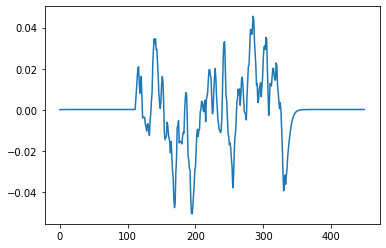

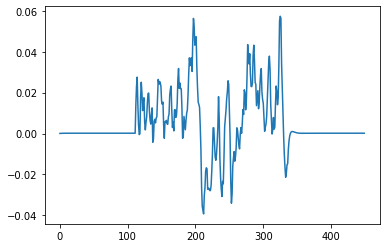

In [7]:
noise = np.random.normal(0, 1, (2, gan.latent_dim))
gen_seqs = gan.generator.predict(noise).reshape(2, gan.seq_length)
plt.figure()
plt.plot(gen_seqs[0])
plt.figure()
plt.plot(gen_seqs[1])